### Notebook

In [139]:
import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [140]:
#Keep this stuff fixed in a whole run

D = 1
N = 1
means = np.random.uniform(-2,2,D+1)
scales = np.linspace(0.5,2,D+1)
print(means)
print(scales)
# define left and right bounds for sampling
left_r = np.min(means)-3*np.max(scales)
right_r = np.max(means)+3*np.max(scales)
base = right_r-left_r

[-0.94825702  0.21046343]
[0.5 2. ]


In [141]:
print(right_r)

6.210463429569887


An event is defined by $(\theta, z)$, where $\theta$ is $D$-dimesional and $z$ is $N$-dimensional. For now keep $N=1$.

The toy model states the following:
$$
p(z|theta) = \frac{(\mathcal{N}_0(z)+\theta_a\mathcal{N}^a(z))^2}{(\sigma(\theta))}
$$

where the normal gaussian $\mathcal{N}_a$ are defined by the first cell (random means)

In [142]:
def unnormed_prob(event):
    n_trials = np.shape(event)[0]
    theta_coefficients = (event[:,0:D])
    theta_coefficients = np.column_stack(((np.ones(n_trials)),theta_coefficients))
    z_events = event[:,D]
    function_values = []
    for (m,s) in zip(means,scales):
        function_values.append(norm.pdf(z_events,loc=m,scale=s))
    return np.sum(np.asarray(function_values).T*theta_coefficients,axis=1)**2
    

In [143]:
#Find maximum for integration
theta_events = np.random.uniform(-4,4,(1000000,D))
z_events = np.random.uniform(left_r,right_r,1000000)
events = np.column_stack((theta_events,z_events))
height = np.max(unnormed_prob(events))

In [144]:
def simulation_random_theta(n_reps):
    #Simulate  in order to get to n_reps accepted counts
    effective_number = 0
    total_number = 0
    zs = []
    ths = [[0]*D]
    while effective_number < n_reps:
        theta_events = np.random.uniform(-4,4,(n_reps,D))
        z_events = np.random.uniform(left_r,right_r,n_reps)
        events = np.column_stack((theta_events,z_events))
        probabilities = unnormed_prob(events)
        mask = probabilities > np.random.uniform(0,height,n_reps)
        true_events = events[mask]
        thetas = true_events[:,0:D]
        z = true_events[:,D]
        if np.sum(mask>0):
            ths += list(thetas)
            zs += list(z)
        effective_number += np.sum(mask)
        total_number += n_reps
    sigma = effective_number/total_number*height*base*8**D
    return thetas, z, sigma

In [145]:
def simulation_fixed_theta(n_reps,th):
    #Simulate  in order to get to n_reps accepted counts
    effective_number = 0
    total_number = 0
    zs = []
    ths = [[0]*D]
    while effective_number < n_reps:
        theta_events = np.full((n_reps,D),th)
        z_events = np.random.uniform(left_r,right_r,n_reps)
        events = np.column_stack((theta_events,z_events))
        probabilities = unnormed_prob(events)
        mask = probabilities > np.random.uniform(0,height,n_reps)
        true_events = events[mask]
        thetas = true_events[:,0:D]
        #print(thetas)
        z = true_events[:,D]
        if np.sum(mask>0):
            ths += list(thetas)
            zs += list(z)
        effective_number += np.sum(mask)
        total_number += n_reps
    ths.pop(0)
    sigma = effective_number/total_number*height*base
    return ths, zs, sigma

In [146]:
a = np.random.uniform(-1,1,(3,1))
A = a@a.T

In [147]:
[1]+[1,2,3]

[1, 1, 2, 3]

In [199]:
def diff_weights(theta):
    thetas = np.asarray([1]+list(theta)).reshape(D+1,1)
    matrix = thetas@thetas.T
    for i in range(D+1):
        for j in range(D+1):
            if i != j:
                matrix[i][j] = matrix[i][j]*2
    return np.asarray(matrix[np.triu_indices(D+1)])

def matrix_system(basis):
    m = []
    for elem in basis:
        m.append(diff_weights(elem))
    return m

def cross_section(basis,theta):
    basis_cross_sections = []
    for elem in basis:
        basis_cross_sections.append(simulation_fixed_theta(100000,elem)[2])
    print(basis_cross_sections)
    return diff_weights(theta)@(np.linalg.inv((matrix_system(basis))))@basis_cross_sections


In [200]:
def der(basis,b,i):
    ws = diff_weights(basis[b])
    return ws[i]

def fish_ij(basis,i,j):
    s = 0
    for b in range((int((D**2+D)/2+D+1))):
        s+=der(basis,b,i)*der(basis,b,j)
    return s
def fish(basis):
    m = []
    for i in range(D):
        row = []
        for j in range(D):
            row.append(fish_ij(basis,i,j))
        m.append(row)
    return m

def cov(basis):
    basis = np.reshape(basis,(int((D**2+D)/2+D+1),D))
    inv = np.linalg.inv(fish(basis))
    #print(np.linalg.det(fish(basis)))
    return np.trace(inv)

In [201]:
(int((D**2+D)/2+D+1))*D

3

In [202]:
np.random.uniform(-20,20,(int((D**2+D)/2+D+1))*D)

array([ 17.76750436, -13.39949568,  -1.3902577 ])

The shape of the basis should be $\frac{D^2+D}{2}+D+1$

In [208]:
minimal = minimize(cov,np.random.uniform(-20,20,(int((D**2+D)/2+D+1))*D))
print(minimal["fun"])
basis = minimal["x"].reshape((int((D**2+D)/2+D+1),D))
print(simulation_fixed_theta(10000,100*np.ones(D))[2])
print(cross_section(basis,100*np.ones(D)))

0.3333333333333333
21.493781240138592
[6.854209460746944, 9.255404730269642, 14.251960311080685]
-712.7587333987085


/Users/giovannidecrescenzo/miniconda3/envs/madminer/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


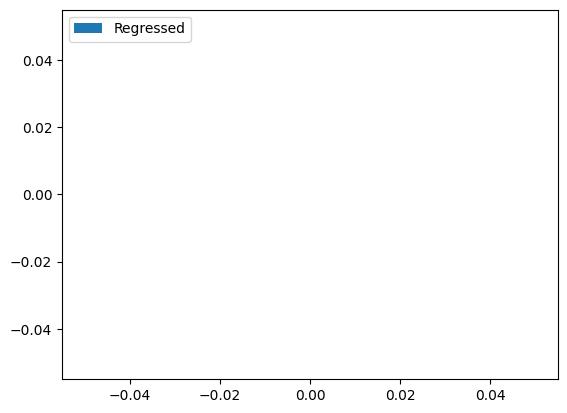

In [116]:
#plt.hist(p,label="True",density=True)
plt.hist(p1,label="Regressed",density=True)
plt.legend()

In [ ]:
def fun(th)

In [243]:
basis_cross_sections = []

for elem in basis:
    basis_cross_sections.append(simulation_fixed_theta(100000,elem)[2])

In [204]:
cross_sections_coefficients = np.linalg.inv(matrix_system(basis))@basis_cross_sections

In [205]:
cross_sections_coefficients

array([1.64763368, 0.48943329, 0.23307566, 0.26166767, 0.15454767,
       0.18439497, 0.15292265, 0.1011256 , 0.20817286, 0.21085598])